In [1]:
# library to make requests to a web page, and print the responce text
import requests 
import re
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from time import sleep
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys

import urllib.parse as urlparse
from urllib.parse import parse_qs

import folium

from IPython.display import display, clear_output

import json

import webbrowser as web# to open urls instantly


In [2]:
#Input your location of interest, dates and visitors
location = 'Kefalonia'
country = 'Greece'

month_in = '07'
month_out = '07'

day_in = '10'
day_out = '20'

year = 2023

persons = 2

pages_to_load = 17 # main page has been loaded. pages_to_load depicts the appended pages to load. 

# -----------------------------------------------------------------------------------------------------------------------------
if pages_to_load >=15:
    pages_to_load = 14
# -----------------------------------------------------------------------------------------------------------------------------

nights = int(day_out) - int(day_in)
if nights <= 0:
    if month == '06' or month == '8': # June & August have 30 days
        nights = 30 - int(day_in) + int(day_out)
    else: # July & September have 31 days
        nights = 31 - int(day_in) + int(day_out)
print(f'You have asked {pages_to_load+1} pages for visiting {location},{country} from {day_in}-{month_in}-{year} to {day_out}-{month_out}-{year} for {persons} visitors')
print(f'Selected Nights are:{nights}')

You have asked 18 pages for visiting Kefalonia,Greece from 10-07-2023 to 20-07-2023 for 2 visitors
Selected Nights are:10


In [3]:
# Create a string with the main link
main_link = 'https://www.airbnb.gr/s/{5}--{6}/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&price_filter_input_type=0&price_filter_num_nights={7}&date_picker_type=calendar&source=structured_search_input_header&search_type=filter_change&query={5}%2C%20{6}&checkin={0}-{1}-{2}&checkout={0}-{8}-{3}&adults={4}'#&place_id=ChIJywtkGTF2X0YRZnedZ9MnDag
None

In [4]:
MainPages_list = []
MainPages_list.append(main_link.format(year,month_in,day_in,day_out,persons,location,country,nights,month_out))
print(MainPages_list[0]) # print the page

https://www.airbnb.gr/s/Kefalonia--Greece/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&price_filter_input_type=0&price_filter_num_nights=10&date_picker_type=calendar&source=structured_search_input_header&search_type=filter_change&query=Kefalonia%2C%20Greece&checkin=2023-07-10&checkout=2023-07-20&adults=2


In [5]:
# Function to load the page and return text of soup
def pageLoad(link,k):
    i = 0
    while i<10:
        sleep(i*2)       
        try:
            html_pages = []   # create a list with the html code for every page
            
            html = requests.get(link.format(year,month_in,day_in,day_out,persons,location,country,nights,month_out)) # Get the page (requests)
            
            html_pages.append(html) # append the html code to the previous list
            # Get the content from the list of pages . html_pages_content is also a list 
            html_pages_content = [html.content for html in html_pages]
            # This is the first element of the list 
            html = html_pages_content[0]
            soup = BeautifulSoup(html, "html.parser")
            rows = soup.find('div', class_= 'gh7uyir giajdwt g14v8520 dir dir-ltr').find_all('meta') 
            print(f'Page {k} loaded')

            break
        except:
            i += 1
            if i < 10:
                print(f'Loading Page {k} was unsuccessful for {i} time(s). Trying loading again' )
            else:
                print(f'FATAL ERROR: Trial No.{i} was unsuccessful. Page cannot be loaded.' )
            sleep(1)
    return rows,soup#,c

# gh7uyir giajdwt g1xypvzw g14v8520 dir dir-ltr
# gh7uyir giajdwt g14v8520 dir dir-ltr
# gh7uyir giajdwt g14v8520 dir dir-ltr
# gh7uyir giajdwt g14v8520 dir dir-ltr

In [6]:
# Function to create a list of urls
def createLists(rows):
    name_lst = []
    url_lst = []
    for i in range(0,len(rows)):
        if 'itemprop="name"' in str(rows[i]):
            name_lst.append(str(rows[i]))
            name_lst[len(name_lst)-1] = name_lst[len(name_lst)-1].replace('<meta content="','')
            name_lst[len(name_lst)-1] = name_lst[len(name_lst)-1].replace('" itemprop="name"/>','')
        elif 'www.airbnb.gr' in str(rows[i]):
            url_lst.append('https://' + str(rows[i]))
            url_lst[len(url_lst)-1] = url_lst[len(url_lst)-1].replace('<meta content="','')
            url_lst[len(url_lst)-1] = url_lst[len(url_lst)-1].replace('" itemprop="url"/>','')   
    return name_lst,url_lst

In [7]:
def Prices(page): 
    t1 = []
    t2 = []
    #page = main_link.format(year,month,day_in,day_out,persons,location,country,nights)
    html = requests.get(page)
    t = re.compile(r'span class="a8jt5op dir dir-ltr">€.+ανά διανυκτέρευση')
    text = t.findall(html.text)
    ls = text[0].split(">€")
    for item in ls:
        if 'ανά διανυκτέρευση' in item and (len(item) <= 1000):
            t1.append(int(item[1:4])) # 1:3 
        if 'συνολικά</span><' in item and len(item)<=600:
            t2.append(item[0:7])
    return t1,t2

In [8]:
# Function to find the url of the next page
def nextPage(soup):
    l = len(soup.find('div', class_= 'c1bp99s5 dir dir-ltr').find_all('a')) - 1
    next_page = str(soup.find('div', class_= 'c1bp99s5 dir dir-ltr').find_all('a')[l])#.find('class', class_='_1bfat5l')
    start = next_page.find('href="')
    end = next_page.find('">')
    next_page = next_page[start+6:end]
    next_page = 'https://www.airbnb.gr'+next_page.replace('amp;','')
    #print(next_page)
    return next_page

In [9]:
name_lst = []
url_lst = []
coords = {}

In [10]:
rows,soup = pageLoad(main_link,1) # load and parse the main link
name_lst, url_lst = createLists(rows) # returns a list of names and urls (and prices ????)

n = soup.find("span", class_="to8eev7 dir dir-ltr").text # span to find the number of appartments with the desired characteristics
n = n.split(' ')

#Number of houses
j = 0
for i in n:
    try:
        try:
            j = int(i)
        except:
            j = float(i)
            j *= 1000
    except:
        pass
print('Appartments for rent:', int(j))

Page 1 loaded
Appartments for rent: 1000


In [11]:
# following command has been replaced with block 2 and command 'pages_to_load'. 
# For loading the max number of pages un-comment the folllowing
# If pages > 15 then max mages are 15 (=15*18 = 270 appartments to show)
# pages_to_load = int(j)/20 - 1 # main page has been loaded. MAXIMUM pages to load
# if pages_to_load >= 15:
#     pages_to_load = 15


In [12]:
# complete the lists of names of appartments and urls of main pages (with max the selected )
for i in range(1,pages_to_load+1):
    next_page= nextPage(soup)

    MainPages_list.append(next_page)
    rows,soup = pageLoad(next_page,i+1)
    name_lst2, url_lst2 = createLists(rows)
    
    for rep in range(len(name_lst2)):
        name_lst.append(name_lst2[rep])
        url_lst.append(url_lst2[rep])
print('Loading has been completed')

Page 2 loaded
Page 3 loaded
Page 4 loaded
Page 5 loaded
Page 6 loaded
Page 7 loaded
Page 8 loaded
Page 9 loaded
Page 10 loaded
Page 11 loaded
Page 12 loaded
Page 13 loaded
Page 14 loaded
Page 15 loaded
Page 16 loaded
Page 17 loaded
Page 18 loaded
Loading has been completed


In [13]:
print(f'Length of Names List: {len(name_lst)}, Length of url List: {len(url_lst)}')

Length of Names List: 324, Length of url List: 324


In [14]:
pricePerNight_list = []
totalPrice_list = []

cond=True
url_number = 1
for url in MainPages_list:
    
    pricePerNight,totalPrice = Prices(url)
    if len(pricePerNight) == len(totalPrice) == 18:
        pricePerNight_list.append(pricePerNight)
        totalPrice_list.append(totalPrice)
        print(f'Url {url_number} Prices: OK')
        url_number += 1
    else:
        rep = 1
        print(f'Url {url_number} Prices: FATAL ERROR')
        sleep(2*rep)
        while cond==True or rep == 4:
            print(f'Repetition {rep}')
            print(f'Length of PricesperNight List: {len(pricePerNight_list)}, Length of Total Prices List: {len(totalPrice_list)}')
            pricePerNight,totalPrice = Prices(url)
            if len(pricePerNight) == len(totalPrice) == 18:
                pricePerNight_list.append(pricePerNight)
                totalPrice_list.append(totalPrice)
                print(f'Url {url_number} prices: OK')
                cond=False
                url_number += 1
            else:
                print(f'Length of PricesperNight List: {len(pricePerNight_list)}, Length of Total Prices List: {len(totalPrice_list)}')
                print('-'*50)
                rep += 1
                sleep(rep*2)
            if rep == 4:
                print(f'Repetition {rep}: FATAL ERROR')
                print('-'*50)
                print('@@@SOS@@@   SOMETHING IS WRONG   @@@SOS@@@')
                
                
    # flatening lists
pricePerNight_list = [item for sublist in pricePerNight_list for item in sublist]
totalPrice_list = [item for sublist in totalPrice_list for item in sublist]
totalPrice_list = [''.join(filter(str.isdigit, s)) for s in totalPrice_list]
print(20*'-')
print(20*'-')
print(len(pricePerNight_list),len(totalPrice_list))

if len(url_lst) == len(pricePerNight_list) and len(pricePerNight_list) == len(totalPrice_list):
    print('-'*50)
    print('         EVERYTHING IS FINE!!!       ')
    print('-'*50)
    #sys.exit()
    pass
else:
    print('-'*50)
    print('@@@SOS@@@   SOMETHING IS WRONG   @@@SOS@@@')
    print('-'*50)
    sys.exit()

Url 1 Prices: OK
Url 2 Prices: OK
Url 3 Prices: OK
Url 4 Prices: OK
Url 5 Prices: OK
Url 6 Prices: OK
Url 7 Prices: OK
Url 8 Prices: OK
Url 9 Prices: OK
Url 10 Prices: OK
Url 11 Prices: OK
Url 12 Prices: OK
Url 13 Prices: OK
Url 14 Prices: OK
Url 15 Prices: OK
Url 16 Prices: OK
Url 17 Prices: OK
Url 18 Prices: OK
--------------------
--------------------
324 324
--------------------------------------------------
         EVERYTHING IS FINE!!!       
--------------------------------------------------


Load every single url site and extract information

In [15]:
def coordinates(r): # Find Coordinates for every apartment
    p_lat = re.compile(r'"lat":([-0-9.]+),')
    p_lng = re.compile(r'"lng":([-0-9.]+),')
    lat = p_lat.findall(r.text)[0]
    lng = p_lng.findall(r.text)[0]
    return lat,lng

In [16]:
def urlLoad(url):
    html_pages = []   # create a list with the html code for every page
    #html = requests.get(url)#.format(year,month,day_in,day_out,persons)) # Get the page (requests)
    html_pages.append(url) # append the html code to the previous list
    # Get the content from the list of pages . html_pages_content is also a list 
    html_pages_content = [url.content for url in html_pages]
    # This is the first element of the list 
    url = html_pages_content[0]
    soup = BeautifulSoup(url, "html.parser")
  
    return soup

In [17]:
# function to find baths, bedrooms, and amenities for every appartment
def extractInfo(r,link):
    error = 0
    #visitors
    p_vst = re.compile(r'"detailItems":.+επισκέπτες"},')
    vst = p_vst.findall(r.text)[0].split(':"')[2].split(" ")[0]

    try:
        #beds
        p_beds = re.compile(r'"detailItems":.+ κρεβάτι.+},{"__typename":"BasicListItem","title":"')
        beds = p_beds.findall(r.text)[0].split(' κρεβάτι')[0]
        beds = beds[len(beds)-1]
    except:
        beds = None
        
    #baths
    p_baths = re.compile(r'detailItems".+ μπάνι')
    baths = p_baths.findall(r.text)[0].split(' μπάνι')[0]
    baths = baths[len(baths)-1] 
    if baths == 5:
        baths = 1

    #bedrooms
    p_bedrooms = re.compile(r'επισκέπτες"},{"__typename":"BasicListItem","title":".+ υπνοδωμάτι')
    try:
        bedrooms = p_bedrooms.findall(r.text)[0].split(' υπνοδωμάτι')[0]
        bedrooms = bedrooms[len(bedrooms)-1]
        try:
            bedrooms = int(bedrooms)
        except:
            bedrooms = None
    except:
        bedrooms = None
    
    # Allamenities
    
    i = 1
    p_ame = re.compile(r'"seeAllAmenitiesGroups":.+}],"seeAllAmenitiesButton":{')
    while i <= 5:
        try:
            amenities = p_ame.findall(r.text)
            amenities = amenities[0][24:len(amenities[0])-26]
            break
        except:
            print(f'ERROR No {i}: ',amenities,'. Trying loading again!')
            i += 1
            sleep(i)
            r = requests.get(link)
    if i == 6:
        print('Fatal Error. Page has not been loaded.')
        sleep(2)
        error = 1
    return vst,beds,baths,bedrooms,amenities,error

In [18]:
# 
def jsonFileEdit(file):
    amenitiesGrouplist = []
    amenitiesList = []

    for amenityGroup in json_object: #json_object == file
        if amenityGroup['title'] != 'Δεν περιλαμβάνονται':
            amenitiesGrouplist.append(amenityGroup['title'])

            for amenity in amenityGroup['amenities']:
                if amenity['available'] == True:
                    amenitiesList.append(amenity['title'])      
    return amenitiesGrouplist,amenitiesList

In [19]:
coords = {}
visitors_lst = []
beds_lst = []
baths_lst = []
bedrooms_lst = []

rep = 1
pagesNotLoaded = 0

#amenGroups = set()
amenSet = set()

amenities_list = []

#for page in url_lst:
for i in tqdm(range(len(url_lst))):
    page = url_lst[i]
    amenitiesGroup = []
    amenities = []
    
    # Open url
    html = requests.get(page)

    # Find Coordinates for every apartment
    lat, lng = coordinates(html)
    #print(lat,lng)
    coords[i] = [lat,lng]

    # Scrape url
    soup = urlLoad(html)
    
    # Extract Information from url
    vst, bed, bths, bdrooms, amens, errors = extractInfo(html,page)
    
    visitors_lst.append(vst)
    beds_lst.append(bed)
    baths_lst.append(bths)
    bedrooms_lst.append(bdrooms)
    
    # amens (amenities) is in a form resembles json file. So as such is used
    # json_object is created for every appartment (url) and this is edited in jsonFileEdit function 
    # which created and returns a list of amenities (the group of amenities and the amenities)
    
    try:
        json_object = json.loads(amens)
        amenitiesGroup, amenities = jsonFileEdit(json_object)
        amenities_list.append(amenities)
        amenSet.update(amenities)

    except:
        print('Something goes wrong')
        pass

    pagesNotLoaded += errors
    if pagesNotLoaded > 0:
        print('Pages not loaded:',pagesNotLoaded)
    else:
        #print('All pages have been loaded!')
        pass


  0%|          | 0/324 [00:00<?, ?it/s]

In [20]:
# Obsolete block of code. This will be deleted afterwards

# Create an empty dataframe. amenities for every appartment will be added later 
amenity_df = pd.DataFrame 

In [21]:
#json_object

In [22]:
data = pd.DataFrame.from_dict(coords, orient='index',
                       columns=['latitude', 'longitude'])

In [23]:
#convert coordinates to float from strings
data['latitude'] = data['latitude'].astype(float)
data['longitude'] = data['longitude'].astype(float)

In [24]:
data['url'] = url_lst
data['Name'] = name_lst
data['Beds'] = beds_lst
data['Visitors'] = visitors_lst
data['Bathrooms'] = baths_lst
data['Bedrooms'] = bedrooms_lst
data['Amenities'] = amenities_list

In [25]:
data['PricePerNight'] = pricePerNight_list
data['Total_Price'] = totalPrice_list

In [26]:
try:
    data['Visitors'] = data['Visitors'].astype(int)
except:
    print('Visitors could not be converted to int')
data = data.replace('ό',1) # private bathroom 
data = data.replace('ο',1) # private bathroom 
data = data.replace('α',2) # not private bathroom  
data = data.replace('None','')

try:
    data['Bathrooms'] = data['Bathrooms'].astype(int)
except:
    print('Bathrooms could not be converted to int')

try:
    data['Beds'] = data['Beds'].astype(int)
    #data['Beds'] = data['Beds'].astype(int)
except:
    print('Beds could not be converted to int.Trying Again...')
    try:
        data.dropna(subset='Beds',inplace=True)
        data['Beds'] = data['Beds'].astype(int)
        print('We did it!')
    except:
        print('Beds could not be converted to int...')
        
    
try:
    data['Bedrooms'] = data['Bedrooms'].replace(np.nan,0)
    data['Bedrooms'] = data['Bedrooms'].astype(int)
except:
    print('Bedrooms could not be converted to int')
#try:
#    data['Hangings'] = data['Hangings'].astype(int)
#except:
#    print('Hangings could not be converted to int')   

In [27]:
try:
    data.Total_Price = data.Total_Price.astype(int)
except:
    print('Total Prices could not be converted to int')

In [28]:
# Correction of url
data.url = data.url.str.split('amp;')
data.url = data.url.apply(lambda x: ''.join(map(str, x)))
#web.open(data.url[50]) # open url instantly

In [29]:
data['#_of_Amenities'] = data.Amenities.apply(lambda x:len(x))

In [31]:
# Dataframe to csv file
data.to_csv(f'{year}_{month_in}_appartments.csv',index=False)

In [32]:
# Open saved scv file
#data = pd.read_csv('appartments.csv')

In [33]:
# create a map of appartments
m = folium.Map(location=[38.228921, 20.567190],tiles='Stamen Terrain')

for i in range(0,len(data)):
   folium.Marker(
      location=[data.iloc[i]['latitude'], data.iloc[i]['longitude']],
      popup = data.iloc[i]['url'],
   ).add_to(m)
m

In [34]:
# All amenities are:
amenSet

{'Check-in χωρίς παρουσία οικοδεσπότη',
 'HDTV',
 'HDTV 25" με Κλασική καλωδιακή τηλεόραση',
 'HDTV 32"',
 'HDTV 32" με Netflix',
 'HDTV 32" με Κλασική καλωδιακή τηλεόραση',
 'HDTV 43"',
 'HDTV 43" με Amazon Prime Video, Apple TV, Netflix',
 'HDTV 43" με Κλασική καλωδιακή τηλεόραση, Chromecast',
 'HDTV 49"',
 'HDTV με Amazon Prime Video, Apple TV, Disney+, HBO Max, Netflix',
 'HDTV με Amazon Prime Video, Chromecast, Netflix',
 'HDTV με Amazon Prime Video, Netflix, Κλασική καλωδιακή τηλεόραση',
 'HDTV με Netflix',
 'HDTV με premium καλωδιακή σύνδεση',
 'HDTV με Κλασική καλωδιακή τηλεόραση',
 'Netflix',
 'Wifi',
 'Wifi – 10 Mbps',
 'Wifi – 22 Mbps',
 'Έπιπλα εξωτερικού χώρου',
 'Αίθριο ή μπαλκόνι',
 'Αίθριο ή μπαλκόνι: Ιδιωτική παροχή',
 'Αίθριο ή μπαλκόνι: Κοινόχρηστη παροχή',
 'Αιώρα',
 'Ανεμιστήρας οροφής',
 'Ανεξάρτητο καρεκλάκι μωρού',
 'Ανεξάρτητο καρεκλάκι μωρού - διατίθεται κατόπιν αιτήματος',
 'Ανιχνευτής καπνού',
 'Ανιχνευτής μονοξειδίου του άνθρακα',
 'Απλώστρα ρούχων',
 'Αρτο

In [35]:
# The wanted amenities could be:
wanted_amenities = ['Wifi',
                    'Αίθριο ή μπαλκόνι',
                    'Απλώστρα ρούχων',
                    'πάρκινγκ',
                    'Είδη πρώτης ανάγκης',
                    'Ζεστό νερό',
                    'Θέα',
                    'Κλιματιστικό',
                    'κλιματισμός',
                    'Κλινοσκεπάσματα',
                    'Κουζίνα',
                    'Μαγειρικά είδη',
                    'Φούρνος',
                    'Ψυγείο',
                    'Πιστολάκι μαλλιών'
]

bathrooms = 1
beds = 2
bedrooms = 2
 

In [36]:
try:
    filtered_data = pd.DataFrame()
except:
    pass
filtered_data = data[data.Beds >= beds]

In [37]:
try:
    filtered_data['Bathrooms'] = filtered_data['Bathrooms'].astype(int)
except:
    print('Bathrooms could not be converted to int')
    try:
        filtered_data = filtered_data.replace('ο',1) # private bathroom 
        filtered_data['Bathrooms'] = filtered_data['Bathrooms'].astype(int)
        print('Done')
    except:
        filtered_data['Bathrooms'].unique()
        print('NO')


C:\Users\user\AppData\Local\Temp\ipykernel_6868\2777163628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Bathrooms'] = filtered_data['Bathrooms'].astype(int)


In [38]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 0 to 322
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        203 non-null    float64
 1   longitude       203 non-null    float64
 2   url             203 non-null    object 
 3   Name            203 non-null    object 
 4   Beds            203 non-null    int32  
 5   Visitors        203 non-null    int32  
 6   Bathrooms       203 non-null    int32  
 7   Bedrooms        203 non-null    int32  
 8   Amenities       203 non-null    object 
 9   PricePerNight   203 non-null    int64  
 10  Total_Price     203 non-null    int32  
 11  #_of_Amenities  203 non-null    int64  
dtypes: float64(2), int32(5), int64(2), object(3)
memory usage: 16.7+ KB


In [40]:
filtered_data = filtered_data[filtered_data.Bedrooms >= bedrooms]
filtered_data = filtered_data[filtered_data.Bathrooms >= bathrooms]
filtered_data = filtered_data[filtered_data.Beds >= beds]
filtered_data = filtered_data[filtered_data['#_of_Amenities'] >= len(wanted_amenities)]

In [42]:
filtered_data = filtered_data.sort_values('Total_Price',ascending=False,ignore_index=True)
#sorted_filtered_data
print(f'There are {filtered_data.shape[0]} appartments with the desired amenities')

There are 52 appartments with the desired amenities


In [43]:
#filtered_data = filtered_data2

<AxesSubplot:xlabel='#_of_Amenities', ylabel='PricePerNight'>

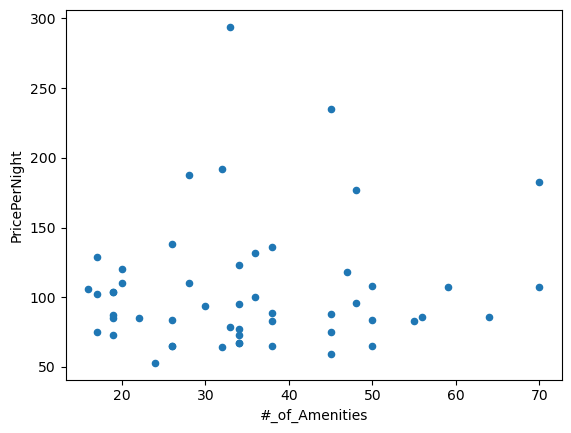

In [44]:
filtered_data.plot(x='#_of_Amenities',y='PricePerNight',kind='scatter')

<AxesSubplot:xlabel='Beds'>

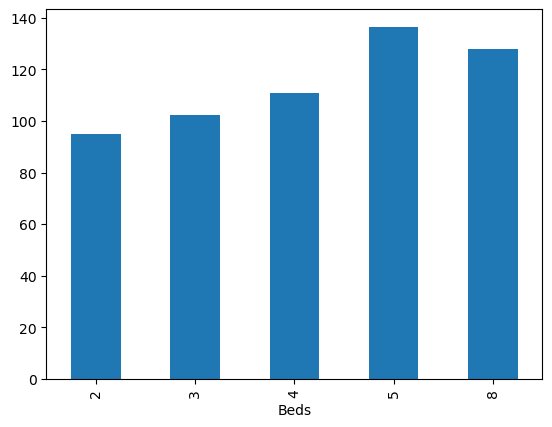

In [45]:
filtered_data.groupby('Beds')['PricePerNight'].mean().plot(x='Beds',y='PricePerNight',kind='bar')
#filtered_data.groupby('Beds')['PricePerNight'].mean().plot(x='Beds',y='PricePerNight',kind='bar')

<AxesSubplot:xlabel='Visitors'>

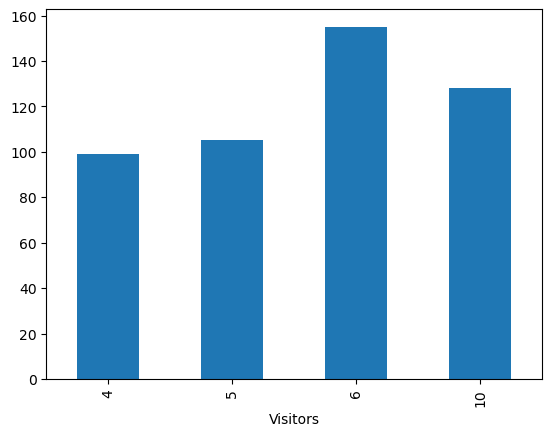

In [46]:
filtered_data.groupby('Visitors')['PricePerNight'].mean().plot(x='Visitors',y='PricePerNight',kind='bar')